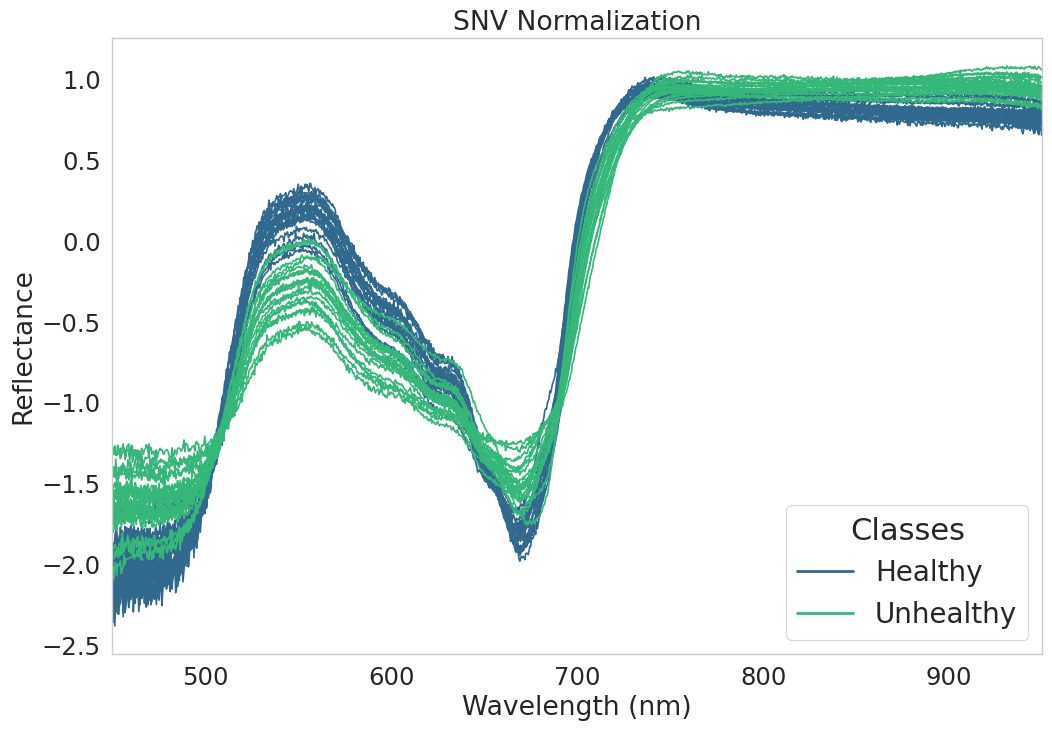

<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../spectral_data.csv')

wavelengths_to_select = df[(df['Wavelength'] <= 950) & (df['Wavelength'] >= 450)]['Wavelength'].unique()
date_to_select = ['24-01-29', '24-02-01', '24-02-02']
date_to_select = ['24-01-29', '24-01-30', '24-01-31', '24-02-01', '24-02-02']
date_to_select = ['24-01-29', '24-02-02']

n_df = df[df['Wavelength'].isin(wavelengths_to_select) & df['Date'].isin(date_to_select) & df['Acquisition'].isin([1])].reset_index(drop=True)

# Do the mean of the various N
n_df['Reflectance_avg'] = n_df.groupby(['Date', 'Position', 'Acquisition', 'Wavelength'])['Reflectance'].transform('mean')
n_df = n_df.drop_duplicates(subset=['Date', 'Position', 'Acquisition', 'Wavelength']).reset_index(drop=True)
# n_df = n_df.drop(columns=['Reflectance', 'N'])
# n_df = n_df.drop(columns=['N'])

n_df.loc[n_df.Date == '24-02-02', 'Class'] = 'Unhealthy'  
n_df.loc[n_df.Date == '24-02-01', 'Class'] = 'Unhealthy'  
n_df.loc[n_df.Date == '24-01-31', 'Class'] = 'Unhealthy'  
n_df.loc[n_df.Date == '24-01-30', 'Class'] = 'Healthy' 
n_df.loc[n_df.Date == '24-01-29', 'Class'] = 'Healthy' 

# print(n_df.Position.unique())
# print(len(n_df.Position.unique()))

n_df['Reflectance_avg_log'] = np.log10(n_df['Reflectance'])

# Apply a lambda function to normalize 'Reflectance' values between 0 and 100, using SNV normalization
col_group = ['Class', 'Date', 'Position', 'Acquisition', 'N']
col_group = ['Class', 'Date', 'Position', 'Acquisition']

grouped = n_df.groupby(col_group)
n_df['Reflectance_SNV_norm'] = grouped['Reflectance_avg_log'].transform(lambda x: (x - x.mean()) / x.std())
# n_df['Reflectance_SNV_norm'] = grouped['Reflectance'].transform(lambda x: (x - x.mean()) / x.std())

table = n_df.pivot_table(index=col_group, columns='Wavelength', values='Reflectance_SNV_norm')

# Take all uniquq values of the 'Class' column and map them to a color
all_classes = n_df['Class'].unique()[::-1]

# Define a color palette and map colors to labels
palette = sns.color_palette("viridis", n_colors=len(all_classes))

color_mapping = {}
for i, c in enumerate(all_classes):
    color_mapping[c] = palette[i]

plt.figure(figsize=(12, 8))
sns.set_context("paper", font_scale=2)  # Adjust font scale for better readability
sns.set_style("whitegrid")

# Iterate over the index of the pivot table
i = 0
for index, row in table.iterrows():
    # print(f'Index: {index[0]}')
    sns.lineplot(row, label=index[0], color=color_mapping[index[0]])
    i += 1

# Manually create a legend with unique labels and their colors
from matplotlib.lines import Line2D

# Create legend handles
legend_elements = [Line2D([0], [0], color=color_mapping[label], lw=2, label=label) for label in color_mapping]
plt.legend(handles=legend_elements, title="Classes", fontsize=20, title_fontsize=22)

# use only the wavelengths in the plot
plt.xlim(450, 950)

# Adding title and labels
plt.title("SNV Normalization")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.rc('xtick')
plt.rc('ytick')
plt.grid(False)

plt.show()
# creae folder if it does not exist
import os
if not os.path.exists('plots'):
    os.makedirs('plots')
    
# Save the plot
plt.savefig('plots/CARS_PLS_DA_SNV_plot.pdf')